# PyTorch: Variable, Gradientes e Grafo Computacional

## Objetivos

Este notebook introduz
- o conceito de `Variables` do PyTorch,
- uma interpretação numérica intuitiva do gradiente, e o
- grafo computacional, utilizado para o cálculo automático do gradiente de uma função.

Um dos principais fundamentos para que o PyTorch seja adequado para deep learning é a sua habilidade de
calcular o gradiente automaticamente a partir da expressões definidas. Essa facilidade é implementada
pelo tipo Variable do PyTorch, que adiciona ao tensor a facilidade de cálculo automático do gradiente pela construção dinâmica do grafo computacional.

## Grafo computacional

```
    y_pred = x * w
    e = y_pred - y
    e2 = e**2
    J = e2.sum()
```

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/GrafoComputacional.png)

Variable possui 3 campos: o dado em si (data), o gradiente (grad) e um apontador (creator) para construir o grafo da backpropagation. Uma expressão utilizada para o cálculo do gradiente exige que todas suas expressões sejam calculadas com Variables, caso contrário não é possível construir o grafo computacional.

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/variables.png)

In [1]:
import torch
from torch.autograd import Variable

## Variable é criada a partir de um tensor e possui as mesmas funcionalidades

In [15]:
y_t = 2 * torch.arange(0.,4.) # Tensor: [0, 2, 4, 6]
y = Variable(y_t); y # Transforma em Variable -> cálculo automático do gradiente pela construção do grafo computacional

tensor([0., 2., 4., 6.])

In [16]:
x = Variable(torch.arange(0.,4.)); x # Tensor: [0, 1, 2, 3]

tensor([0., 1., 2., 3.])

In [17]:
w = Variable(torch.ones(1),requires_grad=True); w # Escalar, inicializado em 1, com autograd ativado. É equivalente a declarar explicitamente Variable

tensor([1.], requires_grad=True)

## Cálculo automático do gradiente da função perda J

Seja a expressão: $$ J = ((x  w) - y)^2 $$

Queremos calcular a derivada de $J$ em relação a $w$.

### Montagem do grafo computacional

In [18]:
# predict (forward)
y_pred = x * w # Predição: [0, 1, 2, 3] * w

# cálculo da perda J: loss
e = y_pred - y # Erro: predição - alvo
e2 = e.pow(2)  # Erro quadrático
J = e2.sum()   # Soma de quadrados -> função de custo (loss)
J

tensor(14., grad_fn=<SumBackward0>)

## Auto grad - processa o grafo computacional backwards

O `backward()` varre o grafo computacional a partir da variável a ele associada e calcula o gradiente para todas as `Variables` que possuem o atributo `requires_grad` como verdadeiro.
O `backward()` destroi o grafo após sua execução. Isso é intrínsico ao PyTorch pelo fato dele ser uma rede dinâmica.

In [19]:
J.backward() # Aqui, o pytorch navega pelo grafo computacional e calcula a derivada de J em relação a w -> dJ/dw
print(w.grad)

tensor([-28.])


In [20]:
w.grad.data.zero_(); # Zera o gradiente

## Interpretação do Gradiente

O gradiente de uma variável final (J) com respeito à outra variável de entrada (w) pode ser interpretado como o quanto a variável final J vai aumentar se houver um pequeno aumento na variável de entrada (w).
Por exemplo suponha que o gradiente seja 28. Isto significa se aumentarmos a variável w de 0.001, então J vai aumentar de 0.028.

In [23]:
eps = 0.001
y_pred = x * (w+eps)
J_new = (y_pred - y).pow(2).sum() # Aproximação númerica do gradiente
J_new

tensor(13.9720, grad_fn=<SumBackward0>)

In [24]:
print((J_new - J).data.numpy())

-0.027988434


## Back propagation

Uma forma equivalente explícita de calcular o gradiente é fazendo o processamento do backpropagation no grafo computacional, de forma explícita.
Apenas como ilustração.

Função de perda:
$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$

Gradiente:
$$  \mathbf{\nabla{J_w}} = \frac{2}{M}\mathbf{x^T}(\mathbf{x w^T} - \mathbf{y}) $$

Atualização dos parâmetros pelo gradiente descendente:
$$ \mathbf{w} = \mathbf{w} − \eta (\mathbf{\nabla J_w})^T $$

In [25]:
import numpy as np

dJ = 1.                                  # dJ/dJ = 1
de2 = dJ * np.ones((4,))                 # ∂J/∂e2_i = 1
de = de2 * 2 * e.data.numpy()            # ∂e2_i/∂e_i = 2e_i
dy_pred = de                             # ∂e_i/∂y_pred = 1
dw = (dy_pred * x.data.numpy()).sum()    # Regra da cadeia
print(dJ)
print(de2)
print(de)
print(dw)


1.0
[1. 1. 1. 1.]
[ 0. -2. -4. -6.]
-28.0


## Visualizando o grafo computacional

In [11]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to c:\users\mathe\appdata\local\temp\pip-req-build-hv8l0b5s
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz 'C:\Users\mathe\AppData\Local\Temp\pip-req-build-hv8l0b5s'


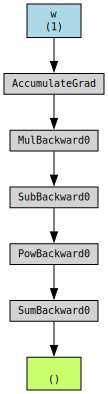

In [26]:
from torchviz import make_dot, make_dot_from_trace
J = ((w * x) - y).pow(2).sum()
p = {'w':w} # dicionário de parâmetros
out = make_dot(J,params=p)      # Gera o grafo computacional que mostra todas as operações feitas e como elas dependem de w
out  


# Exercícios

## Questões

1. Por que numa expressão computacional não é possível misturar `Variable` com tensores?
- Variable é um tipo especial que armazena um grafo computacional, enquanto tensor é apenas um tipo de dado, tal qual um array, por exemplo.
2. O que acontece com o grafo computacional após execução do `backward()`?
- Após chamar backward(), como foi feito acima com J.backward(), o pytorch libera o grafo computacional por padrão para economizar memória.

Referências:
- https://discuss.pytorch.org/t/what-is-the-difference-between-tensors-and-variables-in-pytorch/4914/2
- https://sebarnold.net/tutorials/beginner/examples_autograd/two_layer_net_autograd.html
- https://docs.pytorch.org/docs/stable/generated/torch.Tensor.backward.html
- https://medium.com/biased-algorithms/what-does-the-backward-function-do-8d8e535afa9d#:~:text=By%20default%2C%20backward()%20frees,in%20memory%20for%20further%20use.

## Atividades

1. Execute um passo de atualização do valor de w, pelo
gradiente descendente. Utilize um fator de aprendizado (*learning rate*) de 0.1
para atualizar o `w`. Após, recalcule a função de perda:

    - w = w - lr * w.grad.data
    - execute a célula 1.3.1 e verifique o quanto que a perda J diminuiu
    
2. No trecho abaixo, uma rede bastante conhecida, `resnet18` contendo 18 camadas
   é criada, tendo
   como entrada `xin` que é convertida para `Variable`, resultando na saída `y`.
   
   Descomente a linha que cria a vizualização do grafo computacional e execute a
   célula para visualizar o grafo computacional da rede `resnet18`:

In [29]:
# Atividade 1
x = Variable(torch.arange(0., 4.))
y = Variable(2 * torch.arange(0., 4.))  # y = [0, 2, 4, 6]
w = Variable(torch.ones(1), requires_grad=True)  # w = 1

y_pred = x * w
J = ((y_pred - y).pow(2)).sum()  # função de custo
print("J antes da atualização:", J.item())

J.backward()

lr = 0.1
w.data = w.data - lr * w.grad.data  # atualiza w
print("Novo valor de w:", w.item())

w.grad.data.zero_()

y_pred = x * w
J_novo = ((y_pred - y).pow(2)).sum()
print("J depois da atualização:", J_novo.item())


J antes da atualização: 14.0
Novo valor de w: 3.799999952316284
J depois da atualização: 45.35999298095703


In [13]:
!pip install torchvision
from torchvision import models
xin = torch.randn(1,3,224,224)
resnet18 = models.resnet18()
y = resnet18(Variable(xin))


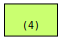

In [30]:
# Atividade 2
g = make_dot(y, dict(resnet18.named_parameters()))
g

# Aprendizados com este notebook

No começo do notebook, o foco era entender como o gradiente é calculado com o tipo Variable. Foi feito o seguinte:
1. Montamos a função de perda J(w)
2. Usamos J.backward() para obter o gradiente
3. Imprimimos w.grad, mas não alteramos w
4. Também foi feita uma validação numérica desse gradiente via diferença finita, e foi mostrado o grafo computacional

Conclusão: Estávamos apenas analisando o comportamento da função e seu gradiente, sem modificar os parâmetros.

Na atividade 1, entramos com o processo de aprendizado da seguinte forma:
1. Calculamos o gradiente como antes
2. Usamos o resultado do gradiente para atualizar w
3. Recalculamos a função de custo J(w) com o novo valor de w

Conclusão: Isso simula o processo real de uma rede neural -> ajustar os parâmetros para minimizar a perda com base no gradiente.

Em suma, o grande aprendizado desse notebook foi chegar no mesmo resultado que chegamos nos notebooks anteriores, porém de maneira mais direta com outros tipos do pytorch, que abstraem muitos cálculos que eram feitos de forma mais explícita utilizando o numpy